In [1]:
import operator
from typing import Annotated, List, Tuple, TypedDict
import os
from dotenv import load_dotenv
from typing import Literal
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_community.chat_models import ChatZhipuAI
# pip install langgraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
import requests
import json

In [15]:
import os
from dotenv import load_dotenv
from langchain_core.tools import tool

# 加载 .env 文件中的环境变量
load_dotenv(dotenv_path='D:/02File/05练习项目/04llm_learning/KEYs.env', override=True)


weather_api_key = os.environ["WEATHER_API_KEY"]

def city_code_search(city_name: str) -> str:
    """
    输入城市名称，返回城市代码。
    """
    # 打开并读取JSON文件
    with open('tools/city_code.json', 'r', encoding='utf-8') as file:
        data = json.load(file)
    # 访问数据
    for province in data['list']:
        for city in province['list']:
            if city['name'] == city_name:
                return city['city_id']
    return None
# 定义工具函数，用于代理调用外部工具
@tool
def search(city_name: str) -> str:
    """
    输入城市名称，获取天气信息。
    """
    city_code = city_code_search(city_name)
    if city_code:
        # API 地址
        url = "http://api.yytianqi.com/observe"
        # 可选的查询参数
        params = {
            "city": city_code,
            "key": weather_api_key
        }
        # 发送 GET 请求
        response = requests.get(url, params=params)
        # 检查响应状态码
        if response.status_code == 200:
            # 解析返回的数据（假设是 JSON 格式）
            data = response.json()
            # print(f"API Response Data: {data}")
            tq = data['data']['tq']
            qw = data['data']['qw']
            return f"查询城市当前天气{tq}，气温{qw}度。"
        else:
            print(f"Error: {response.status_code}")   
    else:
        return "不支持查询该城市的天气"
    
print(search.invoke("北京"))

查询城市当前天气阴，气温19度。


In [3]:
# 加载 .env 文件中的环境变量
load_dotenv(dotenv_path='D:/02File/05练习项目/04llm_learning/KEYs.env', override=True)
# 获取 API 密钥
llm_api_key = os.environ["ZHIPUAI_API_KEY"] 
tavily_api_key = os.environ["TAVILY_API_KEY"]

llm = ChatZhipuAI(
    model="GLM-4-Air",
    api_key=llm_api_key,
    temperature=0
)

# 定义一个TypedDict类PlanExecute，用于存储输入、计划、过去的步骤和响应
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [18]:
# 定义工具函数，用于代理调用外部工具
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_api_key = os.environ["TAVILY_API_KEY"]
# 创建TavilySearchResults工具，设置最大结果数为1
tools = [TavilySearchResults(max_results=1, tavily_api_key=tavily_api_key), search]

In [19]:
from langgraph.prebuilt import create_react_agent

# 从LangChain的Hub中获取prompt模板，可以进行修改
# prompt = hub.pull("wfh/react-agent-executor")
# prompt.pretty_print()

# 创建一个REACT代理执行器，使用指定的LLM和工具，并应用从Hub中获取的prompt
agent_executor = create_react_agent(llm, tools)

In [20]:
agent_executor.invoke({"messages": [("user", "查找2024年巴黎奥运会100米自由泳决赛冠军")]})

{'messages': [HumanMessage(content='查找2024年巴黎奥运会100米自由泳决赛冠军', additional_kwargs={}, response_metadata={}, id='ff20e105-eb7a-4026-8f9f-d7f92d345b4c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "2024年巴黎奥运会100米自由泳决赛冠军"}', 'name': 'tavily_search_results_json'}, 'id': 'call_-8724726985298640660', 'index': 0, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 289, 'total_tokens': 313}, 'model_name': 'GLM-4-Air', 'finish_reason': 'tool_calls'}, id='run-aa7ce630-ed70-4394-947a-002d4212aa3d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024年巴黎奥运会100米自由泳决赛冠军'}, 'id': 'call_-8724726985298640660', 'type': 'tool_call'}]),
  ToolMessage(content='[{"title": "男子100米决赛| 游泳| 2024年巴黎奥运会 - Olympics.com", "url": "https://www.olympics.com/zh/video/men-s-100m-freestyle-final-swimming-olympic-games-paris-2024", "content": "巴黎奥运会游泳男子100米自由泳决赛于2024年7月31日在巴黎拉德芳斯体育馆举行。潘展乐（中国）以46.40秒的新

In [40]:
agent_executor.invoke({"messages": [("user", "今天大连市天气怎么样")]})

{'messages': [HumanMessage(content='今天大连市天气怎么样', additional_kwargs={}, response_metadata={}, id='2c9250dc-88b5-4963-badc-3f64d7dd8380'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"city_name": "大连"}', 'name': 'search'}, 'id': 'call_-8724726779140144497', 'index': 0, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 282, 'total_tokens': 292}, 'model_name': 'GLM-4-Air', 'finish_reason': 'tool_calls'}, id='run-5b78b31d-3005-4bee-9a47-d0f16688b602-0', tool_calls=[{'name': 'search', 'args': {'city_name': '大连'}, 'id': 'call_-8724726779140144497', 'type': 'tool_call'}]),
  ToolMessage(content='Error: TypeError("\'NoneType\' object is not subscriptable")\n Please fix your mistakes.', name='search', id='c000a65e-d906-4c39-a2f0-50fba198218c', tool_call_id='call_-8724726779140144497', status='error'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"city_name": "大连"

In [42]:
search("大连")

KeyError: 'data'

In [22]:
import re
def extract_all_matches_or_return_full_text(text):
    # pattern = r"'''json\s*([\s\S]*?)\s*'''"
    # matches = re.findall(pattern, text)
    # 使用正则表达式匹配大括号及其内容
    pattern = re.compile(r'(\{.*?\})', re.S) # `re.S` 让 `.` 匹配包括换行符在内的所有字符
    
    # 查找所有匹配项
    matches = pattern.findall(text)
    
    if matches:
        # 如果有匹配项，返回所有匹配结果组成的字符串
        return "\n".join(match.strip() for match in matches)
    else:
        # 如果没有匹配项，返回整个文本
        return text

In [23]:
def parse_plan(res: AIMessage) -> List[str]:
    """
    解析计划字符串，将其转换为列表。
    """
    # print(res)
    plan =  extract_all_matches_or_return_full_text(res.content)
    # 使用json.loads将字符串转换为Python列表
    try:
        return json.loads(plan)
    except json.JSONDecodeError:
        # 如果解析失败，返回一个空列表
        return []

In [24]:
from langchain_core.prompts import ChatPromptTemplate

# 创建一个计划生成的提示模板
planner_prompt = ChatPromptTemplate.from_template("""
    你是一位高效的助手，擅长将复杂的任务分解为一系列简单、具体的步骤，以确保任务可以被准确无误地完成。

    规则：
    - 你的回答应该直接针对上述目标，提出一个简明的逐步计划。
    - 每个步骤都应该是独立且必需的，如果按顺序正确执行这些步骤，将会得到正确的最终答案。
    - 最后一个步骤应当能够直接获得最终的答案。
    - 输出结果的前后不要出现"json"或单引号等无关字符串。
    - 输出结果要严格按照<plan_format>的格式。

    plan_format：
    {{
        "plan":[
            "第一步说明",
            "第二步说明" 
        ]
    }}

    根据以上要求，以下是基于示例目标的生成逐步计划：
    
    示例1：
    “计算3+2*4的结果。”

    结果：
    {{
    "plan":[
    "计算2*4的结果，等于8",
    "计算3+8的结果等于11，为最终答案"
    ]
    }}

    示例2：
    “2024年巴黎奥运会男子乒乓球单打冠军的家乡是哪里?”

    结果：
    {{
    "plan":[
    "查找2024年巴黎奥运会男子乒乓球单打冠军",
    "查找该冠军的家乡"
    ]
    }}

    现在，请根据上述格式和要求，为以下目标制定一个逐步计划：
    {messages}
    """)

In [25]:
planner = planner_prompt | llm | parse_plan

In [134]:
planner.invoke({"messages":"2024年巴黎奥运会100米自由泳决赛冠军的家乡是哪里?请用中文答复"})

{'plan': ['查找2024年巴黎奥运会100米自由泳决赛冠军', '查找该冠军的家乡']}

In [55]:
res

AIMessage(content='{\n"plan":[\n"确定2024年巴黎奥运会100米自由泳决赛的冠军",\n"查找该冠军的个人信息",\n"在个人信息公开信息中找到其家乡"\n]\n}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 338, 'total_tokens': 379}, 'model_name': 'GLM-4-Air', 'finish_reason': 'stop'}, id='run-4d5ca9a5-8234-4f12-b763-ff667a183988-0')

In [26]:
from langchain.prompts import ChatPromptTemplate

json_prompt_template = """任务：你是一个擅长任务拆解和计划更新的助手。你的任务是根据给定的目标、原始计划和已完成的步骤，动态更新当前的执行计划。
                
                规则： 
                - 每个步骤必须独立且完整，确保可以被正确执行;
                - 不要添加任何多余或重复的步骤;
                - 最后一步应直接产出最终答案;
                - 如果还需要继续执行，按照<plan_format>格式返回结果;
                - 如果所有步骤已完成，按照<response_format>格式返回结果;
                - 从<plan_format>和<response_format>中必须且只能选择一种格式返回结果;
                - 输出结果必须为JSON格式;
                - 结果中不要出现"json"等无关字符串。
                
                目标：{input}
                
                原始计划：{plan}
                
                已完成的步骤：{past_steps}
               
                plan_format：
                {{
                    "plan":[
                        "第一步说明",
                        "第二步说明" 
                    ]
                }}
                
                response_format：
                {{
                    "response":"最终答案"
                }}
                
                根据以上要求，以下是基于示例目标、原始计划和已完成步骤更新的计划：
                    
                示例1：
                目标：“2024年巴黎奥运会100米自由泳决赛冠军的家乡是哪里?”
                原始计划：“['查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '查找该冠军的家乡']”
                已完成步骤：“[('查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐（Zhanle Pan）。')]”
            
                结果：
                {{
                "plan":[
                "查找潘展乐的家乡"
                ]
                }}

                示例2：
                目标：“2024年巴黎奥运会100米自由泳决赛冠军的家乡是哪里?”
                原始计划：“['查找潘展乐的家乡']”
                已完成步骤：“[('查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐（Zhanle Pan）。'), ('查找潘展乐的家乡', '潘展乐的家乡是浙江温州。')]”
            
                结果：
                {{
                "response":[
                "2024年巴黎奥运会100米自由泳决赛冠军潘展乐的家乡是浙江温州。"
                ]
                }}
                
                """

# 使用ChatPromptTemplate.from_template()方法创建模板对象
prompt = ChatPromptTemplate.from_template(json_prompt_template)

replanner = prompt | llm | parse_plan

In [27]:
# p = PlanExecute(
#     input = '2024年巴黎奥运会100米自由泳决赛冠军的家乡是哪里',
#     plan = ['查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '查找该冠军的家乡'],
#     past_steps = [('查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐（Zhanle Pan）。')]
# )
p = PlanExecute(
    input = '查找2024年巴黎奥运会100米自由泳决赛冠军的家乡。',
    plan = ['根据已完成的步骤，2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐。下一步是查找该冠军的家乡。'],
    # past_steps = [('查找2024年巴黎奥运会100米自由泳决赛冠军的名字', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐（Zhanle Pan）。'), ('查找潘展乐的家乡', '潘展乐的家乡是浙江温州。')]
    past_steps = [('查找2024年巴黎奥运会100米自由泳决赛冠军', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐，他以46.40秒的新世界纪录成绩夺得了金牌。'), ('根据已完成的步骤，2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐。下一步是查找该冠军的家乡。', '2024年巴黎奥运会男子100米自由泳决赛的冠军潘展乐的家乡是中国浙江省温州市。温州是一个集江、海、湖、岛、瀑、湿地之大成的地方，被誉为“全国游泳之乡”，也是乐水者的天堂。')]
)
res = replanner.invoke(p)

In [28]:
res

{'response': '2024年巴黎奥运会男子100米自由泳决赛的冠军潘展乐的家乡是中国浙江省温州市。'}

In [29]:
from typing import Literal


# 定义一个异步主函数

# 定义一个异步函数，用于执行步骤
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # plan_str = "\n".join(f"{i + 1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # task_formatted = f"""
    # 对于以下计划：
    # {plan_str}
    # 你的任务是执行第{1}步，
    # {task}。
    # """
    agent_response = agent_executor.invoke({"messages": task})
    # print(f"智能体查询结果（看有没有function call）agent_res: {agent_response}")
    return {
        "past_steps": state["past_steps"] + [(task, agent_response["messages"][-1].content)],
    }

# 定义一个异步函数，用于生成计划步骤
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": state["input"]})
    print(plan)
    return plan

# 定义一个异步函数，用于重新计划步骤
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    return output

# 定义一个函数，用于判断是否结束
# 改一下这里**********
def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if ("response" in state and state["response"]) or state["plan"] is None:
        return "__end__"
    else:
        return "agent"

In [30]:
from langgraph.graph import StateGraph, START

# 创建一个状态图，初始化PlanExecute
workflow = StateGraph(PlanExecute)

# 添加计划节点
workflow.add_node("planner", plan_step)

# 添加执行步骤节点
workflow.add_node("agent", execute_step)

# 添加重新计划节点
workflow.add_node("replan", replan_step)

# 设置从开始到计划节点的边
workflow.add_edge(START, "planner")

# 设置从计划到代理节点的边
workflow.add_edge("planner", "agent")

# 设置从代理到重新计划节点的边
workflow.add_edge("agent", "replan")

# 添加条件边，用于判断下一步操作
workflow.add_conditional_edges(
    "replan",
    # 传入判断函数，确定下一个节点
    should_end,
)

# 编译状态图，生成LangChain可运行对象
app = workflow.compile()

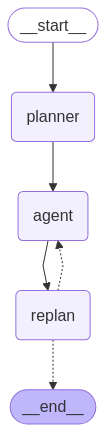

In [31]:
# 设置配置，递归限制为10
config = {"recursion_limit": 10}
# 输入数据
inputs = {"input": "查找2024年巴黎奥运会100米自由泳决赛冠军的家乡。"}
# 异步执行状态图，输出结果
for event in app.stream(inputs, config=config):
    # print(event)
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['查找2024年巴黎奥运会100米自由泳决赛冠军', '查找该冠军的家乡']}
{'plan': ['查找2024年巴黎奥运会100米自由泳决赛冠军', '查找该冠军的家乡']}
{'past_steps': [('查找2024年巴黎奥运会100米自由泳决赛冠军', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐，他以46.40秒的新世界纪录成绩夺得了金牌。')]}
{'plan': ['查找潘展乐的家乡']}
{'past_steps': [('查找2024年巴黎奥运会100米自由泳决赛冠军', '2024年巴黎奥运会男子100米自由泳决赛的冠军是中国选手潘展乐，他以46.40秒的新世界纪录成绩夺得了金牌。'), ('查找潘展乐的家乡', '潘展乐的家乡是中国浙江省的温州市。温州是一个集江、海、湖、岛、瀑、湿地之大成的地方，被誉为“全国游泳之乡”，也是乐水者的天堂。')]}
{'response': '2024年巴黎奥运会100米自由泳决赛冠军的家乡是中国浙江省的温州市。'}


In [32]:
# 设置配置，递归限制为10
config = {"recursion_limit": 10}
# 输入数据
inputs = {"input": "2024年巴黎奥运会男子乒乓球单打冠军的家乡是哪里？"}
# 异步执行状态图，输出结果
for event in app.stream(inputs, config=config):
    # print(event)
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['查找2024年巴黎奥运会男子乒乓球单打冠军', '确定该冠军的家乡']}
{'plan': ['查找2024年巴黎奥运会男子乒乓球单打冠军', '确定该冠军的家乡']}
{'past_steps': [('查找2024年巴黎奥运会男子乒乓球单打冠军', '2024年巴黎奥运会男子乒乓球单打冠军是中国选手樊振东，他在金牌赛中以4:1战胜了瑞典选手特鲁尔斯·莫雷加德。比赛于2024年8月4日在巴黎南部体育馆4号馆举行。')]}
{'plan': ['查找樊振东的家乡']}
{'past_steps': [('查找2024年巴黎奥运会男子乒乓球单打冠军', '2024年巴黎奥运会男子乒乓球单打冠军是中国选手樊振东，他在金牌赛中以4:1战胜了瑞典选手特鲁尔斯·莫雷加德。比赛于2024年8月4日在巴黎南部体育馆4号馆举行。'), ('查找樊振东的家乡', '樊振东的家乡是中国湖南省祁东县。虽然他出生在广州，但他的家庭背景是祁东的，小时候也是由爷爷奶奶在祁东将他带大。')]}
{'response': '2024年巴黎奥运会男子乒乓球单打冠军樊振东的家乡是中国湖南省祁东县。'}


In [33]:
# 设置配置，递归限制为10
config = {"recursion_limit": 10}
# 输入数据
inputs = {"input": "特朗普是哪一年出生的？他的女儿叫什么名字？"}
# 异步执行状态图，输出结果
for event in app.stream(inputs, config=config):
    # print(event)
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['查找唐纳德·特朗普的出生年份', '查找唐纳德·特朗普女儿的名字']}
{'plan': ['查找唐纳德·特朗普的出生年份', '查找唐纳德·特朗普女儿的名字']}
{'past_steps': [('查找唐纳德·特朗普的出生年份', '唐纳德·特朗普出生于1946年。')]}
{'plan': ['查找唐纳德·特朗普女儿的名字']}
{'past_steps': [('查找唐纳德·特朗普的出生年份', '唐纳德·特朗普出生于1946年。'), ('查找唐纳德·特朗普女儿的名字', '唐纳德·特朗普的女儿名叫伊万卡·特朗普（Ivanka Trump）。')]}
{'response': '特朗普出生于1946年，他的女儿名叫伊万卡·特朗普（Ivanka Trump）。'}


In [44]:
# 设置配置，递归限制为10
config = {"recursion_limit": 10}
# 输入数据
inputs = {"input": "北京今天的天气怎么样？"}
# 异步执行状态图，输出结果
for event in app.stream(inputs, config=config):
    # print(event)
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['访问天气查询网站或使用天气查询应用', '输入北京的地理位置信息', '获取并阅读当前的天气信息', '记录下北京今天的天气情况']}
{'plan': ['访问天气查询网站或使用天气查询应用', '输入北京的地理位置信息', '获取并阅读当前的天气信息', '记录下北京今天的天气情况']}
{'past_steps': [('访问天气查询网站或使用天气查询应用', '看起来在尝试访问天气查询网站或使用天气查询应用时，发生了一个错误，提示缺少了 \'data\' 键。这可能意味着在处理返回的数据时，我们试图访问一个不存在的数据字段。\n\n为了解决这个问题，我们需要检查天气查询服务的响应，并确保我们正确地解析了数据。由于我没有具体的代码或服务API的详细信息，我将提供一个通用的解决方案，你可以根据实际情况调整它。\n\n以下是一个示例代码，它尝试获取天气信息并处理可能出现的错误：\n\n```python\n# 假设我们使用一个名为search的函数来获取天气数据\ndef get_weather(city_name):\n    try:\n        # 调用天气查询服务\n        weather_data = search(city_name)\n        \n        # 检查返回的数据中是否有\'data\'键\n        if \'data\' in weather_data:\n            # 正常处理数据\n            return weather_data[\'data\']\n        else:\n            # 如果没有\'data\'键，打印错误信息或抛出异常\n            print("Error: \'data\' key is missing in the response.")\n            return None\n    except KeyError as e:\n        # 捕获KeyError异常，打印错误信息\n        print(f"Error: {e}")\n        return None\n    except Exception as e:\n        # 捕获其他可

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [146]:
# 设置配置，递归限制为10
config = {"recursion_limit": 10}
# 输入数据
inputs = {"input": "计算1+3*（2+3）-4的结果。"}
# 异步执行状态图，输出结果
for event in app.stream(inputs, config=config):
    # print(event)
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['计算括号内的2+3的结果，等于5', '计算3*5的结果，等于15', '计算1+15的结果，等于16', '计算16-4的结果，等于12，为最终答案']}
{'plan': ['计算括号内的2+3的结果，等于5', '计算3*5的结果，等于15', '计算1+15的结果，等于16', '计算16-4的结果，等于12，为最终答案']}
{'past_steps': [('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个简单的数学加法运算。')]}
{'plan': ['计算3*5的结果，等于15', '计算1+15的结果，等于16', '计算16-4的结果，等于12，为最终答案']}
{'past_steps': [('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个简单的数学加法运算。'), ('计算3*5的结果，等于15', '是的，3 乘以 5 的结果是 15。这是一个简单的乘法运算。')]}
{'plan': ['计算1+15的结果，等于16']}
{'past_steps': [('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个简单的数学加法运算。'), ('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个简单的数学加法运算。'), ('计算3*5的结果，等于15', '是的，3 乘以 5 的结果是 15。这是一个简单的乘法运算。'), ('计算1+15的结果，等于16', '计算1+15的结果确实是16。这是一个简单的加法运算。')]}
{'plan': ['计算1+3*（2+3）-4的结果']}
{'past_steps': [('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个简单的数学加法运算。'), ('计算括号内的2+3的结果，等于5', '计算括号内的2+3的结果确实等于5。这是因为：\n\n2 + 3 = 5\n\n这是一个

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT